Load the libraries

In [ ]:
library(caret)
library(dplyr)
library(xlsx)
library(ggplot2)
library(fastDummies)
library(modelr)
library(rpart)


Load the data

In [28]:
data = read.xlsx('ANZ%20synthesised%20transaction%20dataset.xlsx; filename%2A.xlsx', as.data.frame = T,sheetIndex = 1)



In [29]:
head(data)

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,⋯,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,authorized,1,NA,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NA,Diana,⋯,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
2,authorized,0,NA,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NA,Diana,⋯,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
3,authorized,1,NA,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NA,Michael,⋯,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
4,authorized,1,NA,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NA,Rhonda,⋯,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
5,authorized,1,NA,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NA,Diana,⋯,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit
6,posted,NA,NA,ACC-1608363396,AUD,151.22 -33.87,PAYMENT,NA,NA,Robert,⋯,20,NA,NA,2018-08-01T02:00:00.000+0000,163.00,1005b48a6eda4ffd85e9b649dc9467d3,Australia,CUS-2688605418,NA,debit


Cleaning and Pre- Processing data

In [30]:
data_ml <- filter(data, txn_description == 'PAY/SALARY')


# Finding number of unique values 
rapply(data_ml, function(x) length(unique(x)))

# Drop all the columns with just one entry and other irrelevant columns

data_ml <- data_ml[, c('account', 'first_name', 'balance', 'date', 'gender', 'age',
                      "amount", 'customer_id')]



# Calculate annual salary of each individual account holder

data_ml_sal <- data_ml[, c('account', 'balance', 'date',
                           "amount", 'customer_id','gender')]


data_ml_sal$date_diff <- 0
data_ml_sal$An_Salary <- 0


for (i in seq(nrow(data_ml_sal))){
  for (j in ((i+1): seq(nrow(data_ml_sal)))){
    if(i == j){
      next
    }
    if( j > 883 ){
      next
    }
    if(i !=j){
       if (data_ml_sal[i, 1]  == data_ml_sal[j,1]){
          data_ml_sal[i,7] <- abs(as.numeric(data_ml_sal[i,3]-data_ml_sal[j,3]))
      
          data_ml_sal[i,8] = data_ml_sal[i,4]*(364/abs(data_ml_sal[i,7]))
       }
      else{
        next
      }
        
    }
  }
  
}

# some account had some instance of recurring amount of salary on the same day, which resulted in Inf output in 
# 8 accounts, even though the the salary remained the same for previous time-frame and the next time-frame 
# hence assuming that the recurring amount to be a clerical error or other early withdrawal of future salary
# rather than a salary bump


## extract the annual salary of every account (ignore the Inf and zero value)

data_ml_sal[data_ml_sal == 0 | data_ml_sal == Inf] <-  NA

data_ml_sal_cleaned <- data_ml_sal[complete.cases(data_ml_sal),]

data_ml_sal_cleaned <- data_ml_sal_cleaned[!duplicated(data_ml_sal_cleaned$account),]

# data_ml_sal_cleaned now contains the frequency of pay i.e, whether the payment of salary
# is done in weekly basis (7 days), bi weekly basis (14 days) etc.  and the annual salary

## checking all the various frequencies of pay

unique(data_ml_sal_cleaned$date_diff)

## the values contains 31, 30 and 32, this is because of the uneven distribution of number
## of days in a month. 

status card_present_flag  bpay_biller_code           account 
                1                 1                 1               100 
         currency          long_lat   txn_description       merchant_id 
                1               100                 1                 1 
    merchant_code        first_name           balance              date 
                1                80               883                65 
           gender               age   merchant_suburb    merchant_state 
                2                33                 1                 1 
       extraction            amount    transaction_id           country 
              394               100               883                 1 
      customer_id merchant_long_lat          movement 
              100                 1                 1

Warning message in (i + 1):seq(nrow(data_ml_sal)):
“numerical expression has 883 elements: only the first used”
Warning message in (i + 1):seq(nrow(data_ml_sal)):
“numerical expression has 883 elements: only the first used”
Warning message in (i + 1):seq(nrow(data_ml_sal)):
“numerical expression has 883 elements: only the first used”
Warning message in (i + 1):seq(nrow(data_ml_sal)):
“numerical expression has 883 elements: only the first used”
Warning message in (i + 1):seq(nrow(data_ml_sal)):
“numerical expression has 883 elements: only the first used”
Warning message in (i + 1):seq(nrow(data_ml_sal)):
“numerical expression has 883 elements: only the first used”
Warning message in (i + 1):seq(nrow(data_ml_sal)):
“numerical expression has 883 elements: only the first used”
Warning message in (i + 1):seq(nrow(data_ml_sal)):
“numerical expression has 883 elements: only the first used”
Warning message in (i + 1):seq(nrow(data_ml_sal)):
“numerical expression has 883 elements: only the firs

[1]  7 14 28 31 30 32 61

Frequency Distribution of Annual Salaries of Custumors 

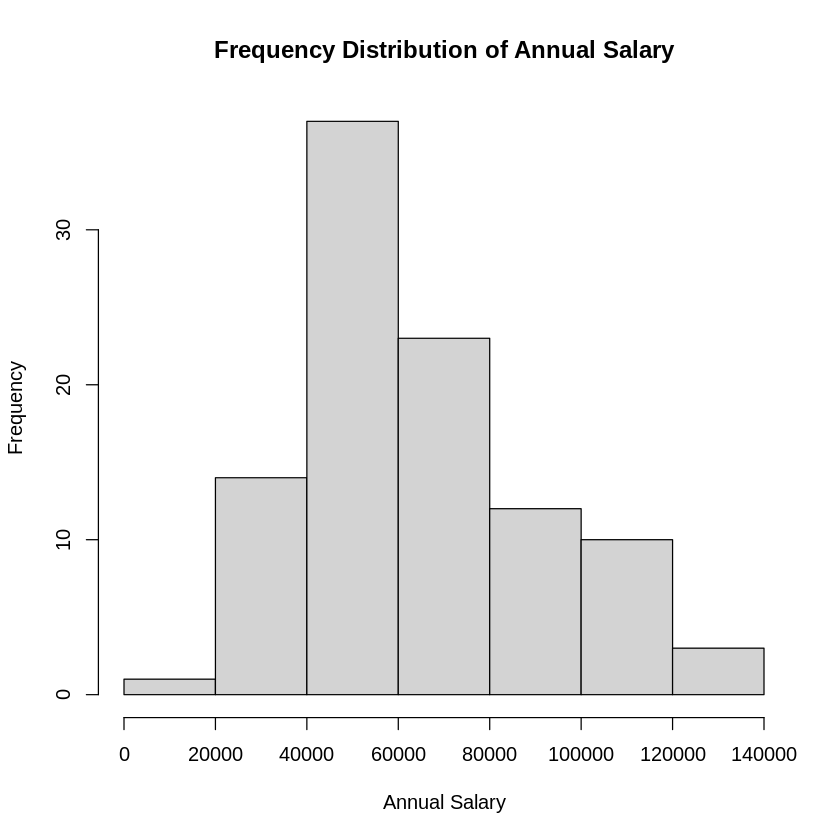

In [31]:
hist(data_ml_sal_cleaned$An_Salary, xlab = 'Annual Salary',
     main = 'Frequency Distribution of Annual Salary')

Cleaning for predictive modelling

In [32]:
## extracting spending from each account

data_ml_spend <- filter(data, txn_description != 'PAY/SALARY')

data_ml_spend_sum <- aggregate(amount~account+age+txn_description+gender, data_ml_spend, sum)


# Merging spending pattern with annual salary

data_ml_Sal_Sp <- merge(data_ml_sal_cleaned, data_ml_spend_sum,  by = 'account')

# drop costumer ID, Balance, and date and amount.x columns

data_ml_Sal_Sp <- data_ml_Sal_Sp %>%
                            select(-date, -amount.x, -balance, -customer_id, -gender.y,-account)

head(data_ml_Sal_Sp)

,gender.x,date_diff,An_Salary,age,txn_description,amount.y
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,F,7,46388.68,40,PAYMENT,844.00
2,F,7,46388.68,40,SALES-POS,3445.86
3,F,7,46388.68,40,POS,3399.41
4,M,28,41535.13,22,POS,675.54
5,M,28,41535.13,22,INTER BANK,909.00
6,M,28,41535.13,22,SALES-POS,1299.99


Building a predictive model


In [33]:
## Linear Model

fit <- lm(formula = An_Salary~., data = data_ml_Sal_Sp)

summary(fit)

rmse(fit, data_ml_Sal_Sp)

## Build a decision-tree based model


data_ml_Sal_Sp <- dummy_cols(data_ml_Sal_Sp, select_columns = c('txn_description', 'gender.x'),
                                  remove_selected_columns = T)


inTrain <- createDataPartition(data_ml_Sal_Sp, p = 0.70, list = F)

data_train <- data_ml_Sal_Sp[inTrain,]
data_test <- data_ml_Sal_Sp[-inTrain,]


fit_rpart <- rpart(An_Salary~., data = data_test, control = rpart.control(minsplit = 1, minbucket = 1,cp = 0))


rmse(fit_rpart, data_train)


Call:
lm(formula = An_Salary ~ ., data = data_ml_Sal_Sp)

Residuals:
   Min     1Q Median     3Q    Max 
-40734 -19537  -3986  15382  66807 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                77965.911   5691.199  13.699  < 2e-16 ***
gender.xM                   6177.084   2575.259   2.399 0.016946 *  
date_diff                   -713.799    155.681  -4.585  6.2e-06 ***
age                         -137.097    115.413  -1.188 0.235632    
txn_descriptionPAYMENT    -10557.212   4115.710  -2.565 0.010704 *  
txn_descriptionPHONE BANK   2306.672   6947.112   0.332 0.740050    
txn_descriptionPOS         -8630.160   3978.729  -2.169 0.030706 *  
txn_descriptionSALES-POS   -8601.700   3998.100  -2.151 0.032081 *  
amount.y                       3.938      1.166   3.377 0.000811 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 24930 on 374 degrees of freedom
Multiple R-squared:  0.107,	

[1] 24633.08

Warning message in createDataPartition(data_ml_Sal_Sp, p = 0.7, list = F):
“Some classes have no records (  ) and these will be ignored”
Warning message in createDataPartition(data_ml_Sal_Sp, p = 0.7, list = F):
“Some classes have a single record (  ) and these will be selected for the sample”


[1] 39441.67